# Class 2: Comparison of the different models

5/27/2022  
Lei G Renmin Univ. of China

### 1. Positive relation between GPA & Income  
https://www.washingtonpost.com/news/wonk/wp/2014/05/20/heres-how-much-your-high-school-grades-predict-how-much-you-make-today/  

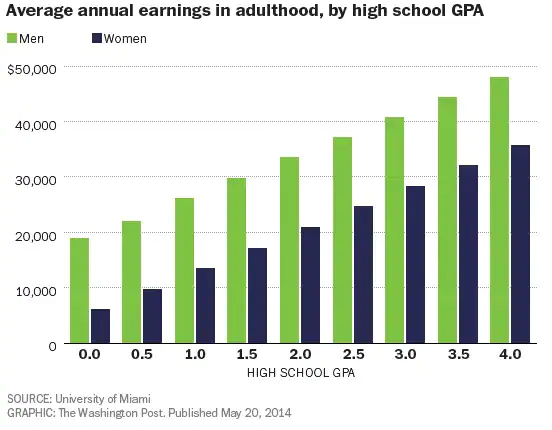

### 2A. Build a simple theoretical economic model and solve the parameters

In [172]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout,BatchNormalization
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeClassifier
from dtreeviz.trees import dtreeviz
from keras_visualizer import visualizer 
from sklearn import tree
import matplotlib.pyplot as plt
import warnings
from scipy.optimize import fsolve
warnings.filterwarnings(action='ignore')
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['PYTHONHASHSEED'] = '0' 
import math


$income=\alpha\log(gpa+constant)$

income=50000, gpa=4  
income=20000, gpa=0

$50000=\alpha\log(4+constant)$

$20000=\alpha\log(constant)$

In [180]:
def func(x):
    return [x[0] * np.log10(4+x[1])-50000 ,
            x[0] * np.log10(x[1])-20000]

### simliar to the matlab fsolve is to solve equations 
root = fsolve(func, (30000, 2))

alpha=root[0]
constant=root[1]

print('alpha is',alpha,'\nconstant is',constant)

alpha is 63928.2012382348 
constant is 2.0551852464729086


### 2B. Plot the theoretical model 

In [5]:
from numba import jit,njit,vectorize

In [6]:
def real_income_gpa_god(gpa):
    """
    the function which has true relation between
    income and gpa, which is in reality can not observe

    gpa: student's gpa between range from 0 to 5
    """
    global alpha,constant
    income=alpha*np.log10(gpa+constant)
    return income

In [7]:
gpa_list=np.linspace(0,5,100000001)
real_income_gpa_god_jit=jit(real_income_gpa_god)
### In Python, to speed up the computation is simple
%timeit income_list=real_income_gpa_god(gpa_list)
%timeit income_list=real_income_gpa_god_jit(gpa_list)

1.29 s ± 16.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
500 ms ± 13.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


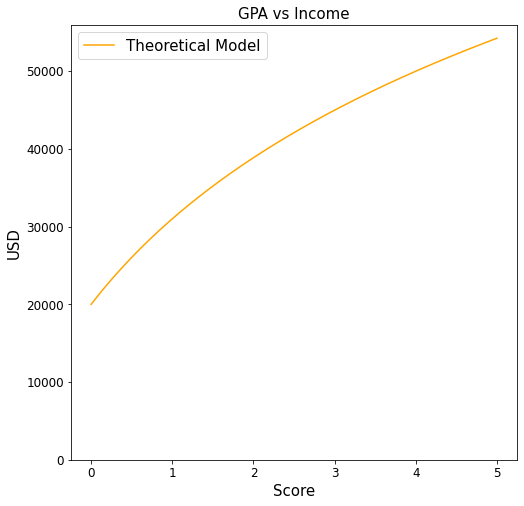

In [8]:
n_sample=10001  
gpa_list=np.linspace(0,5,n_sample)
income_list=real_income_gpa_god(gpa_list)

import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize=(8,8))
ax.plot(gpa_list,income_list,c='orange',label='Theoretical Model')
ax.set_ylim([0,None])
ax.set_title('GPA vs Income',fontsize=15)
ax.set_xlabel('Score',fontsize=15)
ax.set_ylabel('USD',fontsize=15)
ax.tick_params(axis='both',labelsize=12)
ax.legend(loc='best',fontsize=15)

### 3. Generating the testing data from the theoretical model for our statistical model comparison
- Then we use the theoretical model from the section 1 and 2 to randomly generate the data for our statistical modeling test
- Why fake data first?
- Simplify the model, so you can understand clearly in side the black box of the machine learning

To get the data for our statistical models comparsion, we add a random factor $\mu$ to our theoretical model:
$$income=\alpha\log(gpa+constant)+\mu$$,  
where $\mu$ follow a normal distribution $N(0,\sigma)$ and we assume $\sigma=2500$

In [9]:
### control for the random seed lottery, why? 
np.random.seed(666)
np.random.randint(0,2)

0

In [10]:
i=0
while i<10:
    print(np.random.randint(0,2))
    i+=1

0
1
0
0
0
1
0
0
1
1


In [125]:
np.random.seed(666)
income_list2=income_list+2500*np.random.normal(0,1,n_sample)

In [126]:
df=pd.DataFrame()
df['income']=income_list2
df['income_god_model']=income_list
df['gpa']=gpa_list

array([[<AxesSubplot:title={'center':'income'}>,
        <AxesSubplot:title={'center':'gpa'}>]], dtype=object)

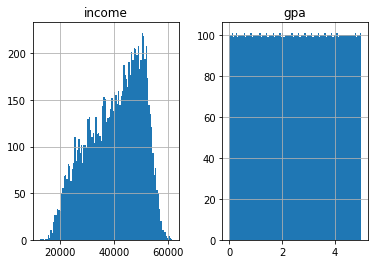

In [127]:
df[['income','gpa']].hist(bins=100)

In [14]:
df.corr()

,income,income_god_model,gpa
income,1.000000,0.967427,0.955912
income_god_model,0.967427,1.000000,0.987991
gpa,0.955912,0.987991,1.000000


In [16]:
def plot_prediction(df,var_name,model_name):
    """
    The function to plot the prediction of the model
        var_name: the name of the prediction in the data frame
        model_name: name of the model 
    """
    fig,ax=plt.subplots(figsize=(8,8))
    ax.plot(df['gpa'],df[var_name],lw=3,ls='-',c='black',label=model_name)
    ax.plot(df['gpa'],df['income_god_model'],lw=3,c='orange',label='Perfect Model')
    ax.scatter(df['gpa'],df['income'],s=3,label='Observed Data',alpha=0.2)
    ax.set_ylim([0,None])
    ax.set_title('GPA vs Income',fontsize=15)
    ax.set_xlabel('Score',fontsize=15)
    ax.set_ylabel('USD',fontsize=15)
    ax.tick_params(axis='both',labelsize=12)
    ax.legend(loc='best',fontsize=15)

In [17]:
def abs_ppe(df,var_name):
    error=((
        df['income']-df[var_name])/df['income']).abs().mean()
    
    print('The average percentage error for the model is: {}%'.format(np.round(error*100,2)))
    return error
    

In [67]:
### First we test the performance of the perfect model

The average percentage error for the model is: 5.33%


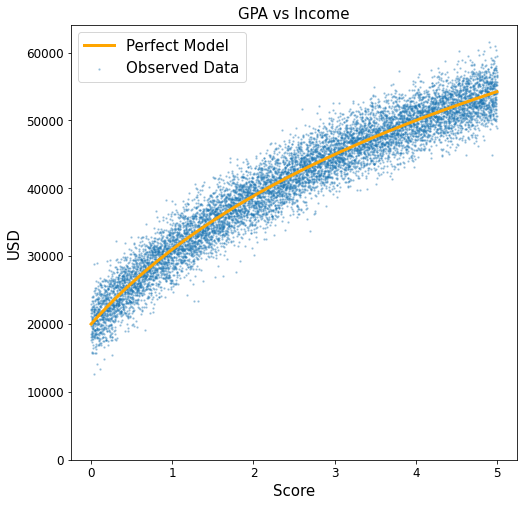

In [70]:
abs_ppe(df,'income_god_model')
fig,ax=plt.subplots(figsize=(8,8))
ax.plot(df['gpa'],df['income_god_model'],lw=3,c='orange',label='Perfect Model')
ax.scatter(df['gpa'],df['income'],s=2,label='Observed Data',alpha=0.3)
ax.set_ylim([0,None])
ax.set_title('GPA vs Income',fontsize=15)
ax.set_xlabel('Score',fontsize=15)
ax.set_ylabel('USD',fontsize=15)
ax.tick_params(axis='both',labelsize=12)
ax.legend(loc='best',fontsize=15)

### 3. Comparsion of different models

#### 3A. Simple statisical model
The simplest way for modeling and prediction is to use just the simple avearge value of the income for the prediction. So far, assuming we don't know the GPA for each person.

The average percentage error for the model is: 24.28%


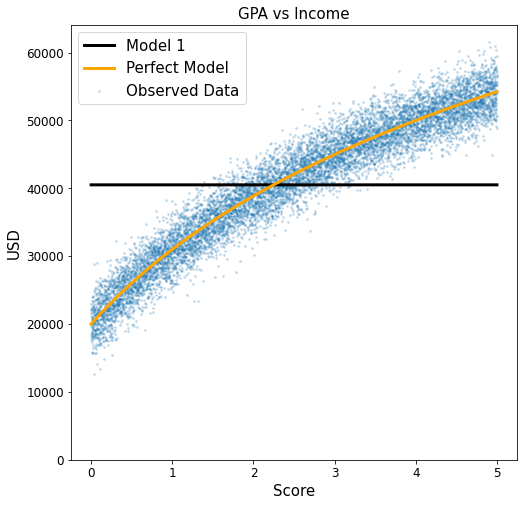

In [18]:
prediction=df['income'].mean()

df['income_model1']=prediction

abs_ppe(df,'income_model1')

plot_prediction(df,'income_model1','Model 1')

### 3B. Model by dividing data into groups

The average percentage error for the model is: 7.36%


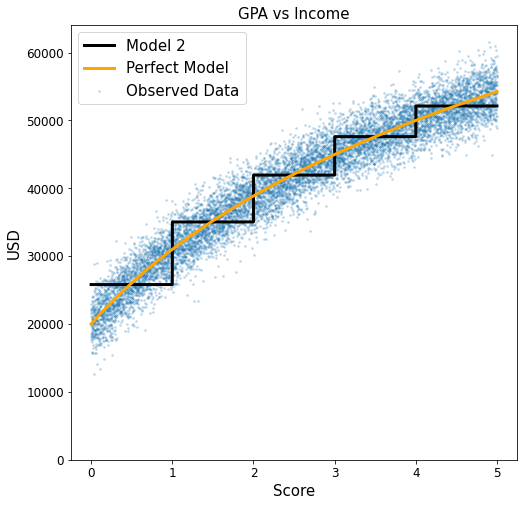

In [19]:
df['gpa_group'],bins=pd.qcut(df['gpa'],5,retbins=True,labels=range(1,6))

df['income_model2']=df['income'].groupby(df['gpa_group']).transform(np.mean)

abs_ppe(df,'income_model2')

plot_prediction(df,'income_model2','Model 2')

### 3C. OLS Model (Matrix Manipulation)

In this section, we use the linear regression model to predict the income.  
The linear regression model:  
$$Income=X*\beta$$  
where $X$ include both GPA and intercept.
Then as we learnt from the econometrics, we do the simple matrix manipulation:
$$X^{T}Income=X^{T}X\beta$$  
$$(X^{T}X)^{-1}X^{T}Income=\beta$$  


Shape of the X Matrix (10001, 2)
Shape of the Y Matrix (10001,)
The parameters of the OLS regression are beta-gpa is 6534.23 beta-intercept is 24176.55:
The average percentage error for the model is: 6.34%


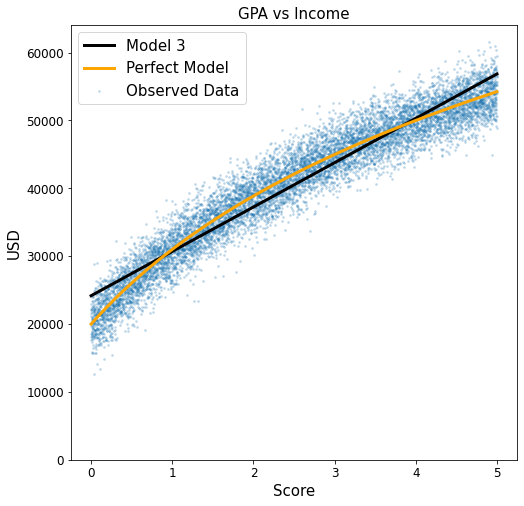

In [99]:
df['intercept']=1

X = df[['gpa','intercept']].values
Y = df['income'].values
 

## X and Y arrays must have the same number of columns for the matrix multiplication to work:
print('Shape of the X Matrix',X.shape)
print('Shape of the Y Matrix',Y.shape)
 
## Use the equation above (X'X)^(-1)X'Y to calculate OLS coefficient estimates:
beta = np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

print('The parameters of the OLS regression \
are beta-gpa is {} beta-intercept is {}:'.format(round(beta[0],2),round(beta[1],2)))
 
df['income_model3']=beta[0]*df['gpa']+beta[1]
abs_ppe(df,'income_model3')
plot_prediction(df,'income_model3','Model 3')

### 3C. OLS Model (statsmodels version)

The results should be same as in the section 3B.

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.914      
Dependent Variable: income           AIC:                187834.2237
Date:               2022-05-27 13:50 BIC:                187848.6445
No. Observations:   10001            Log-Likelihood:     -93915.    
Df Model:           1                F-statistic:        1.060e+05  
Df Residuals:       9999             Prob (F-statistic): 0.00       
R-squared:          0.914            Scale:              8.3977e+06 
--------------------------------------------------------------------
             Coef.    Std.Err.    t     P>|t|    [0.025     0.975]  
--------------------------------------------------------------------
Intercept  24176.5521  57.9503 417.1947 0.0000 24062.9579 24290.1464
gpa         6534.2342  20.0741 325.5062 0.0000  6494.8849  6573.5834
--------------------------------------------------------------------
Omnibus:               20.851        Durbin-Watson:  

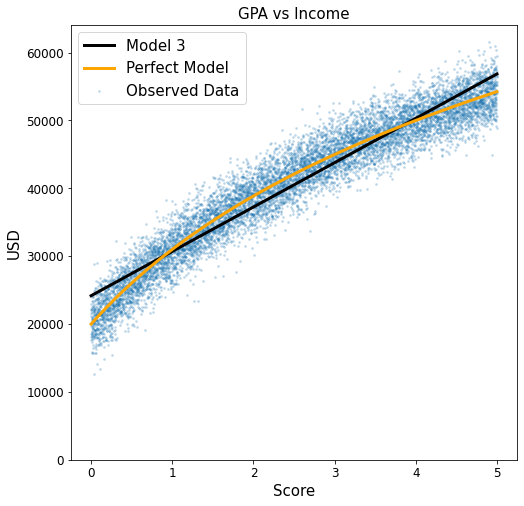

In [101]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
reg_ols=smf.ols('income~gpa',df)
results_ols=reg_ols.fit()
print(results_ols.summary2())
print('The parameters for the OLS are:')
print(results_ols.params)
df['income_model3b']=results_ols.predict(df['gpa'])
abs_ppe(df,'income_model3b')
plot_prediction(df,'income_model3b','Model 3')

### 3D. Machine Learning (Gradient Boosting)

The average percentage error for the model is: 5.24%
Wall time: 654 ms


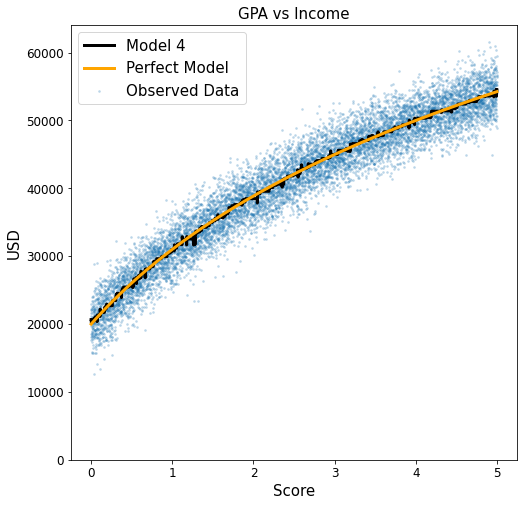

In [66]:
%%time
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree


hyperparameters_gb={'n_estimators':60,'learning_rate':0.1,
                    'criterion':'squared_error',
                    'random_state':666,
                    'max_depth':3
                   }
reg_gb=GradientBoostingRegressor(**hyperparameters_gb)

reg_gb.fit(df[['gpa']],df['income'])

df['income_model4']=reg_gb.predict(df[['gpa']])

abs_ppe(df,'income_model4')

plot_prediction(df,'income_model4','Model 4')

inside the gradient boosting are 60 decision trees

In [122]:
print(reg_gb.estimators_[0:5],'\n...')

[[DecisionTreeRegressor(max_depth=3,
                        random_state=RandomState(MT19937) at 0x203FA051340)]
 [DecisionTreeRegressor(max_depth=3,
                        random_state=RandomState(MT19937) at 0x203FA051340)]
 [DecisionTreeRegressor(max_depth=3,
                        random_state=RandomState(MT19937) at 0x203FA051340)]
 [DecisionTreeRegressor(max_depth=3,
                        random_state=RandomState(MT19937) at 0x203FA051340)]
 [DecisionTreeRegressor(max_depth=3,
                        random_state=RandomState(MT19937) at 0x203FA051340)]] 
...


Let check the tree #1 aka the first tree

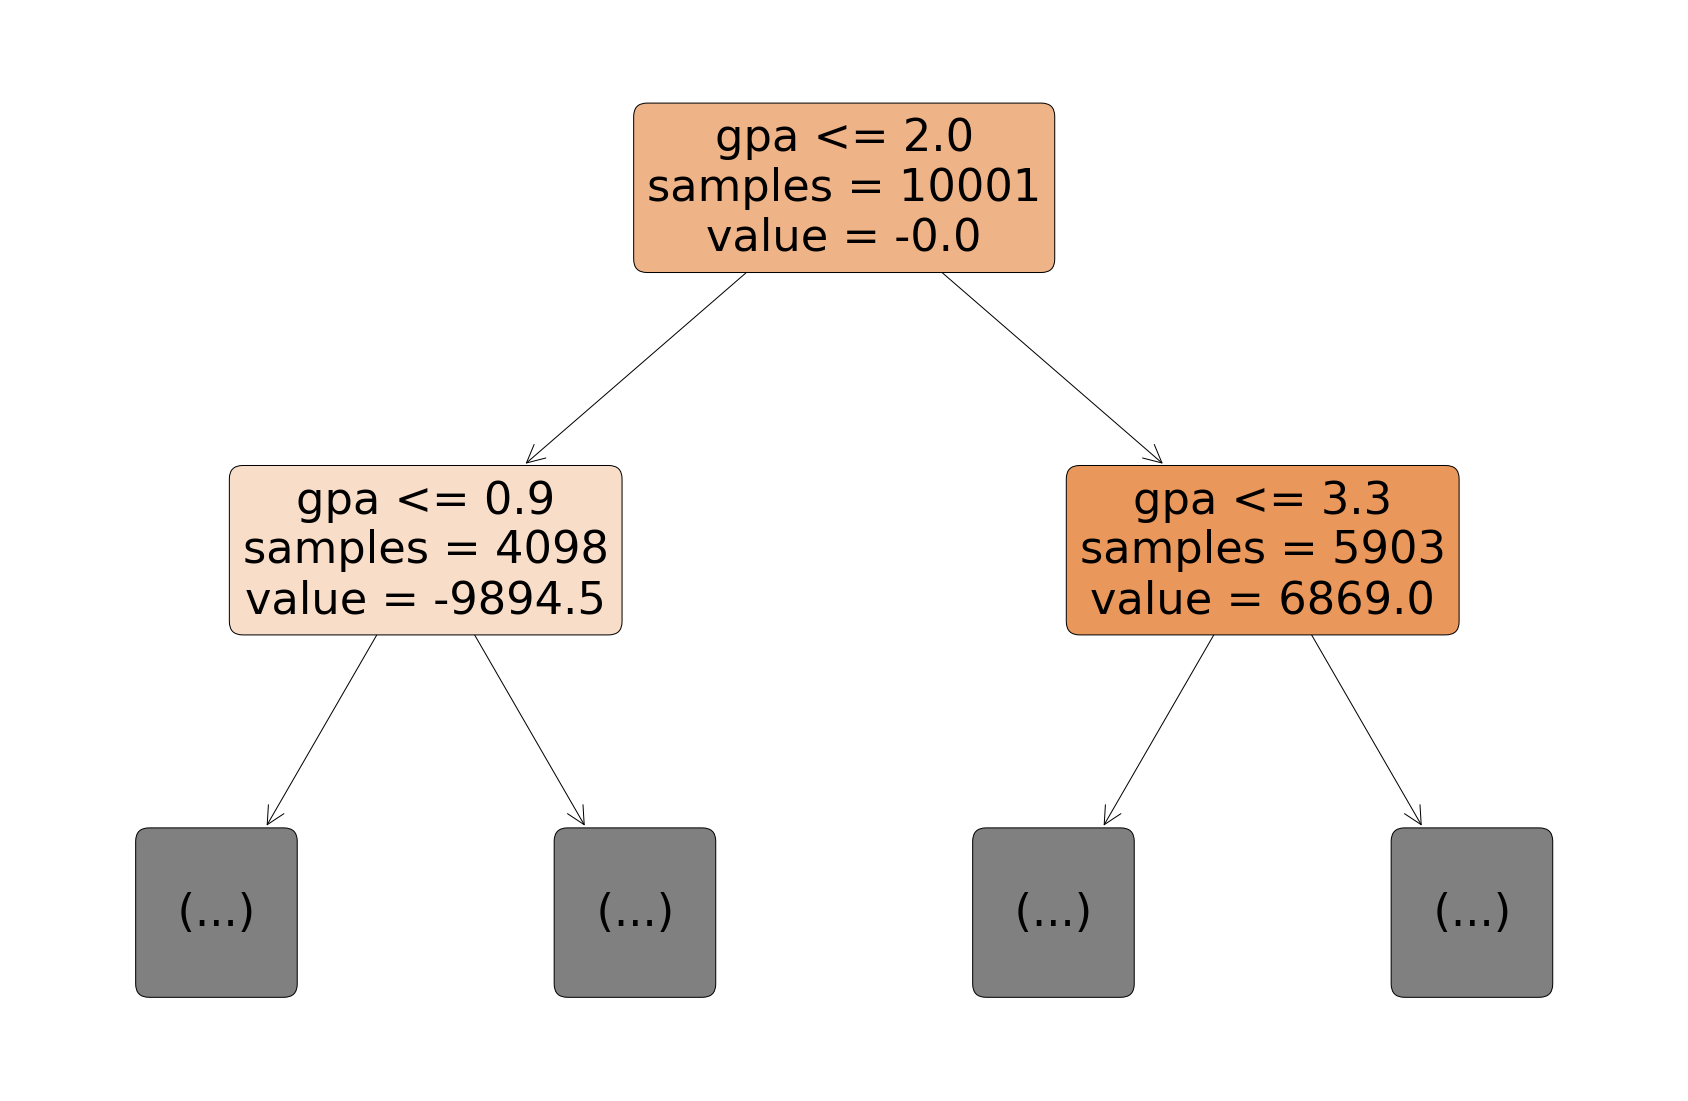

In [35]:
plt.figure(figsize=(30,20)) 
tree.plot_tree(reg_gb.estimators_[0][0],max_depth=1,
               filled=True,feature_names=df[['gpa']].columns,
               rounded=True,precision=1,impurity=False)
plt.show()

In [36]:
from dtreeviz.trees import dtreeviz


In [37]:
viz = dtreeviz(reg_gb.estimators_[0][0], df[['gpa']],df['income'],
                target_name="income",
                feature_names=df[['gpa']].columns,orientation='LR',scale=2,ticks_fontsize=5)
viz.save('tree_model.svg')

### 3F. Neural Network

In [135]:
## standardize the data 
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
df['gpa_scale']=scaler.fit_transform(df[['gpa']])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                20        
_________________________________________________________________
batch_normalization (BatchNo (None, 10)                40        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
batch_normalization_1 (Batch (None, 5)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 141
Trainable params: 111
Non-trainable params: 30
_________________________________________________________________
Epoch 1/90
71/71 - 2s - loss: 1604708096.0000 - mae: 38977.7930 - val_loss: 2692187392.0000 - val_mae: 51820.5352
Epoch 2/9

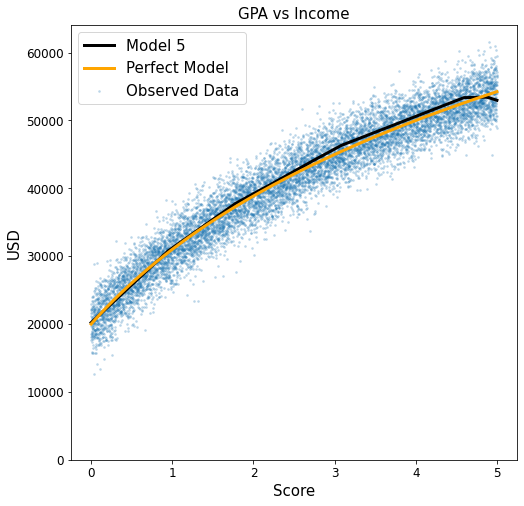

In [159]:
%%time
K.clear_session()
epochs=90
batch_size=128
model_ann = Sequential()
optimizer = keras.optimizers.Adam(lr=0.1)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            patience=5,verbose=1,
                                            restore_best_weights=True)
model_ann.add(Dense(10,activation = 'relu',
                    input_dim = len(df[['gpa_scale']].columns)))
model_ann.add(BatchNormalization())
model_ann.add(Dense(5,activation = 'relu'))
model_ann.add(BatchNormalization())
model_ann.add(Dense(1,activation ='linear'))
model_ann.compile(optimizer =optimizer,loss = 'mse',metrics = ['mae'])
model_ann.summary()

keras.utils.plot_model(model_ann, show_shapes=True, rankdir="TB",dpi=200)

np.random.seed(666)
tf.random.set_seed(666)
with tf.device('/cpu:0'):
    model_ann.fit(df['gpa_scale'],df['income'],
              batch_size=batch_size,epochs=epochs,validation_split=0.1,validation_freq=1,
              verbose=2,callbacks=[callback])
df['income_model5'] = model_ann.predict(df['gpa_scale'],batch_size = 32)

abs_ppe(df,'income_model5')

plot_prediction(df,'income_model5','Model 5')

-------

# Appendix: Stata in Python 

<div class="alert alert-block alert-info">
<b>Tip:</b> YOU NEED TO INSTALL STATA and ipystata First
</div>

In [658]:
import ipystata  #导入ipystata模块  
from ipystata.config import config_stata  #告诉ipystata哪里可以找到stata
config_stata(r"C:\Program Files (x86)\Stata14\StataMP-64.exe", force_batch=False)   #Stata可执行文件路径，根据自己电脑设置

df_stata=df[['income','gpa']].astype

In [660]:
%%stata -d df_stata
reg income gpa


      Source |       SS           df       MS      Number of obs   =    10,001
-------------+----------------------------------   F(1, 9999)      >  99999.00
       Model |  8.8977e+11         1  8.8977e+11   Prob > F        =    0.0000
    Residual |  8.3968e+10     9,999  8397689.66   R-squared       =    0.9138
-------------+----------------------------------   Adj R-squared   =    0.9138
       Total |  9.7374e+11    10,000  97373986.7   Root MSE        =    2897.9

------------------------------------------------------------------------------
      income |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
         gpa |   6534.234   20.07407   325.51   0.000     6494.885    6573.583
       _cons |   24176.55   57.95029   417.19   0.000     24062.96    24290.15
------------------------------------------------------------------------------



In [71]:
%matplotlib inline
from ipywidgets import interactive, fixed

In [74]:
def change_learning_rate(learning_rate=0.1):
    hyperparameters_gb={'n_estimators':60,'learning_rate':learning_rate,
                        'criterion':'squared_error',
                        'random_state':666,
                        'max_depth':3
                       }
    reg_gb2=GradientBoostingRegressor(**hyperparameters_gb)

    reg_gb2.fit(df[['gpa']],df['income'])

    df['income_model_interactive']=reg_gb2.predict(df[['gpa']])
    plot_prediction(df,'income_model_interactive','Model')
    plt.show()

In [76]:
interactive(change_learning_rate, learning_rate=(0.0001, 1.0))

interactive(children=(FloatSlider(value=0.1, description='learning_rate', max=1.0, min=0.0001), Output()), _do…